In [1]:
import numpy as np
from matplotlib import pyplot as plt
# we use the following for plotting figures in jupyter
%matplotlib inline
import GPy
import collections
import timeit
from multiprocessing import Pool
import time
from scipy.interpolate import splev, splprep
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

np.set_printoptions(precision=4)
np.set_printoptions(suppress=True)


/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


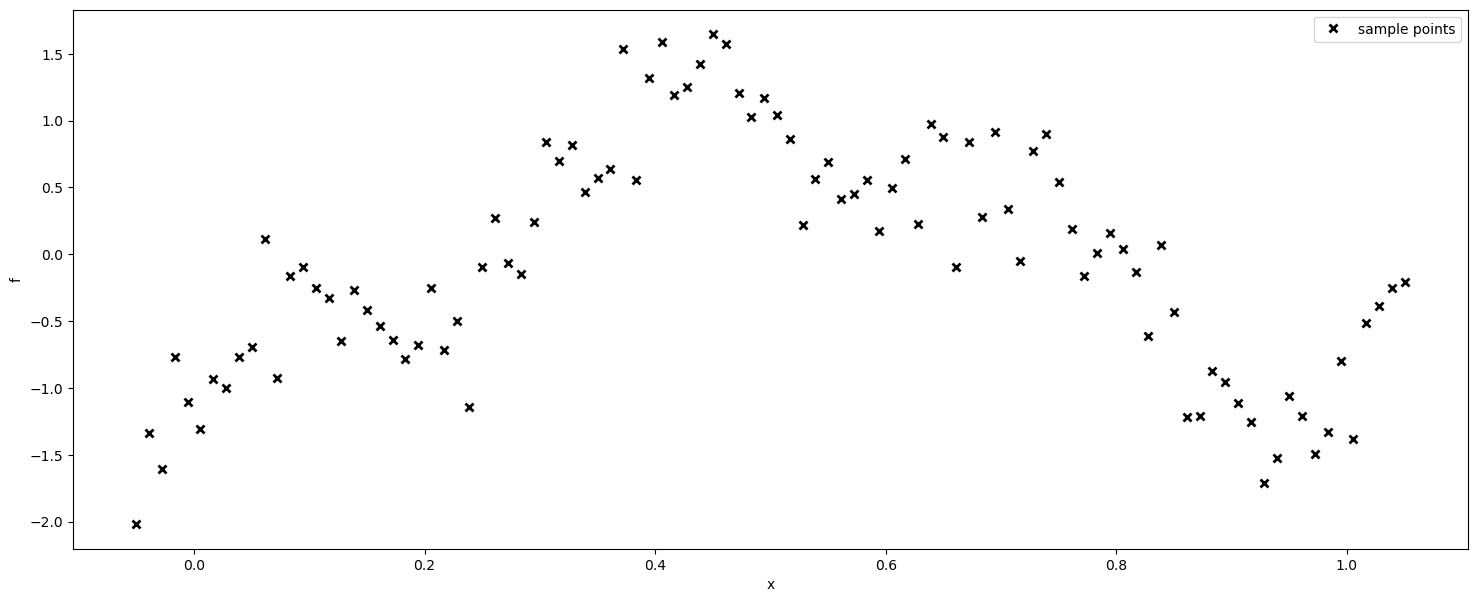

In [17]:
# lambda function, call f(x) to generate data
f = lambda x: -np.cos(2*np.pi*x) + 0.5*np.sin(6*np.pi*x)

# 10 equally spaced sample locations 
#X = np.linspace(0.05, 0.95, 10)[:,None]
# New test points to sample function from
X = np.linspace(-0.05, 1.05, 100)[:, None]


# y = f(X) + epsilon
Y = f(X) + np.random.normal(0., 0.3, (100,1)) # note that np.random.normal takes mean and s.d. (not variance), 0.1^2 = 0.01

# Setup our figure environment
plt.figure(figsize=(18, 7))

# Plot observations
plt.plot(X, Y, "kx", mew=2)

# Annotate plot
plt.xlabel("x"), plt.ylabel("f")
plt.legend(labels=["sample points"]);

In [3]:
def plot_gp(X, m, C, training_points=None):
    """ Plotting utility to plot a GP fit with 95% confidence interval """
    # Plot 95% confidence interval 
    plt.fill_between(X[:,0],
                     m[:,0] - 1.96*np.sqrt(np.diag(C)),
                     m[:,0] + 1.96*np.sqrt(np.diag(C)),
                     alpha=0.5)
    # Plot GP mean and initial training points
    plt.plot(X, m, "-")
    plt.legend(labels=["GP fit"])
    
    plt.xlabel("x"), plt.ylabel("f")
    
    # Plot training points if included
    if training_points is not None:
        X_, Y_ = training_points
        plt.plot(X_, Y_, "kx", mew=2)
        plt.legend(labels=["GP fit", "sample points"])

In [10]:
import multiprocessing as mp

In [5]:
def estimate(X, Y):
    #k2 = GPy.kern.Bias(input_dim=1, variance=2)
    k1 = GPy.kern.RBF(1, variance=1, lengthscale=0.8, name="rbf")
    k1.variance.constrain_bounded(1e-5, 0.1)  # Set variance bounds
    k1.lengthscale.constrain_bounded(1e-3, 5.0)  # Set lengthscale bounds
    
    m = GPy.models.GPRegression(X, Y, k1)
    
    m.Gaussian_noise.variance.fix()
    m.optimize(max_iters=100)
    
    print('lengthscale: {}'.format(m.rbf.lengthscale[0]))
    print('variance: {}'.format(m.rbf.variance[0]))
    mean, cov = m.predict_noiseless(X)
    return mean, cov

In [12]:
def estimate_x3(X,Y):
    m1 = estimate(X,Y)
    m2 = estimate(X+X,Y+Y)
    m3 = estimate(X*3,Y*3)
    m4 = estimate(X,Y)
    m5 = estimate(X+X,Y+Y)
    m6 = estimate(X*3,Y*3)
        
    return np.hstack((m1,m2,m3,m4,m5,m6))


In [13]:
def estimate_parallel(X,Y):
    data_list = [(X, Y), (X+X, Y+Y), (X*3, Y*3), (X, Y), (X+X, Y+Y), (X*3, Y*3)]
    pool = mp.Pool(processes=mp.cpu_count())
    results = pool.starmap(estimate, data_list)
    
    
    
    with Pool(4) as p:
        results = p.starmap(estimate, data_list)
    return results
    


In [14]:
def estimate_3dim(X,Y):
    X3 = np.hstack((X,X+X,X*3))
    Y3 = np.hstack((Y,Y+Y,Y*3))
    
    k1 = GPy.kern.RBF(3, variance=1, lengthscale=0.8, name="rbf1")
    
    
    m = GPy.models.GPMultioutRegression(X3, Y3, 1)
    
    mean, cov = m.predict_noiseless(X3)
    return mean

In [30]:
t0 = time.time()
estimate(X,Y)
t1 = time.time()

print('took {} ms'.format((t1-t0)*1000))

reconstraining parameters rbf.variance
reconstraining parameters rbf.lengthscale


lengthscale: 0.09032477644684864
variance: 0.09999999600168588
took 1310.5652332305908 ms


In [24]:

t0 = time.time()
estimate_x3(X,Y)
t1 = time.time()

print('took {} ms'.format((t1-t0)*1000))

took 3946.851968765259 ms


In [25]:

t0 = time.time()
estimate_parallel(X,Y)
t1 = time.time()

print('took {} ms'.format((t1-t0)*1000))


took 3322.1240043640137 ms


reconstraining parameters rbf.variance
reconstraining parameters rbf.lengthscale


[0.13040043081367272, 0.12151235285003978, 0.11610767471832081, 0.1132096514473149, 0.11191394788091505, 0.11148920405123666, 0.11142394975139655, 0.1114219559169671, 0.11135968562293044, 0.11122547661830492, 0.11105966167643336, 0.11090932640478438, 0.11080349108525037, 0.11074709950796582, 0.1107274326765236, 0.11072521491186973, 0.11072419762387445, 0.11071602540360279, 0.11070021300023, 0.11068103397757037, 0.1106636887322229, 0.11065155648426842, 0.1106452538072866, 0.11064322928835199, 0.11064308868410119, 0.11064282787144566, 0.11064148079175298, 0.1106391102274891, 0.11063637358136233, 0.11063399590765463, 0.11063240639057567, 0.11063163542248974, 0.11063142398775924, 0.11063142284320646, 0.11063136328524828, 0.11063113510528336, 0.11063077027609333, 0.11063037253801097, 0.11063004261035189, 0.1106298331064319, 0.11062974190416366, 0.1106297322627158, 0.11062975996996241, 0.11062979186383834, 0.11062981048529177, 0.11062980940423436, 0.11062978801384973, 0.11062975214388845, 0.

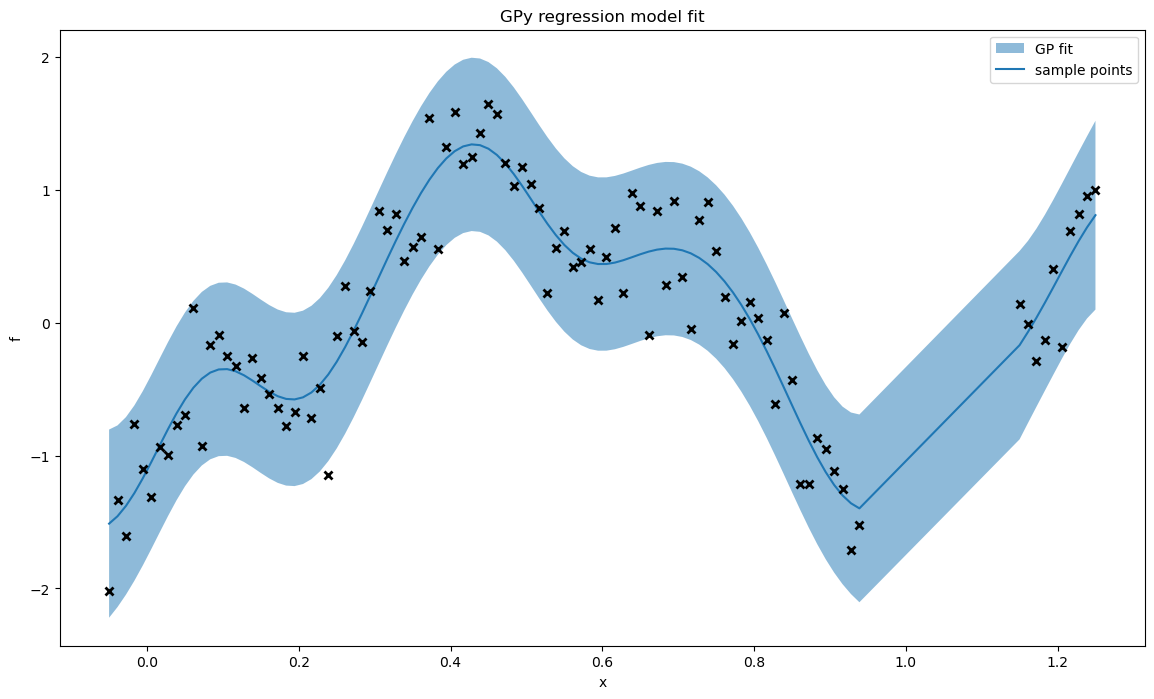

In [40]:
# Use GPy model to calculate the mean and covariance of the fit at Xnew

k1 = GPy.kern.RBF(1, variance=2, lengthscale=0.1, name="rbf")
k1.variance.constrain_bounded(1e-5, 1)  # Set variance bounds
k1.lengthscale.constrain_bounded(1e-3, 1.0)  # Set lengthscale bounds

#Y[-10:] = Y[-10:] + 0.2
m = GPy.models.GPRegression(X, Y, k1)

m.Gaussian_noise.variance = 0.1
m.Gaussian_noise.variance.fix()
#m.optimize(max_iters=1000)
mean, Cov = m.predict(X, full_cov=True)

plt.figure(figsize=(14, 8))

# Plot the GP fit mean and covariance
plot_gp(X, mean, Cov, training_points=(X,Y))
plt.title("GPy regression model fit");
#print(mean)
print([Cov[i,i] for i in range(Cov.shape[0])])

In [82]:
print(mean)

[[-1.11273937]]


In [139]:
def predict_next_y(x, y, new_x):
    """
    Predict the next y for a given x using GPy.

    Parameters:
    x (numpy array): Input data from the last 20 timesteps.
    y (numpy array): Output data from the last 20 timesteps.
    new_x (numpy array): New input for which to predict the output.

    Returns:
    numpy array: Predicted output for the new input.
    """
    # Create a GPRegression model with an RBF kernel
    
    kernel = GPy.kern.RBF(input_dim=1, variance=0.8, lengthscale=1)
    model = GPy.models.GPRegression(x, y, kernel)
    
    # Optimize the model parameters
    model.optimize()
    
    # Predict the mean and variance of the output for the new input
    mean, var = model.predict(new_x)

    # Return the predicted mean
    return mean, var

In [140]:

x = np.array([0,1,2,3,4,5,6,7,8,9])
y = np.array([1,2,3,4,5,6,7,8,9,10])

prediction0, var0 = predict_next_y(x.reshape(-1,1),y.reshape(-1,1), np.array([[100]]))
print(prediction0)
print(var0)

[[97.61243911]]
[[18.40486478]]


In [182]:
def generate_trajectory(points, d_points):
    """generates a smooth trajectory from an array of given points

    Args:
        points (np.ndarray): input points with arbitrary distance
        d_points (float): maximum distance of output points

    Returns:
        np.ndarray: array of points with maximum distance of d_points
    """
    # Calculate the total distance of the trajectory
    total_distance = np.sum(np.linalg.norm(np.diff(points, axis=0), axis=1))

    # Calculate the number of points needed for the trajectory
    n_points = int(total_distance / d_points) + 1

    # Prepare the input for the interpolation function
    #t = np.arange(len(points))
    points = points.T
    
    # Perform the interpolation
    tck, u = splprep(points, s=0.1)
    u_new = np.linspace(u.min(), u.max(), n_points)
    x_new, y_new, z_new = splev(u_new, tck)

    # Return the interpolated points
    return np.array([x_new, y_new, z_new]).T

In [189]:
def generate_trajectory(points, d_points):
    if len(points) < 4:
        # If there are less than 4 points, use linear spline
        
        points = points.T
        tck, u = splprep(points, k=1, s=0)
    else:
        # If there are 4 or more points, use cubic spline
        
        points = points.T
        tck, u = splprep(points, s=0)

    # Calculate the total distance of the trajectory
    total_distance = np.sum(np.linalg.norm(np.diff(points, axis=0), axis=1))

    # Calculate the number of points needed for the trajectory
    n_points = int(total_distance / d_points) + 1

    # Perform the interpolation
    u_new = np.linspace(u.min(), u.max(), n_points)
    x_new, y_new, z_new = splev(u_new, tck)

    # Return the interpolated points
    return np.array([x_new, y_new, z_new]).T


In [198]:

def generate_trajectory(points, d_points):
    trajectory = [points[0]]
    for i in range(len(points) - 1):
        vector = points[i + 1] - points[i]
        distance = np.linalg.norm(vector)
        num_points = int(np.ceil(distance / d_points))
        for j in range(1, num_points + 1):
            point = points[i] + j * vector / num_points
            trajectory.append(point)
    trajectory.append(points[-1])
    return np.array(trajectory)

In [222]:
def generate_trajectory(points, d_points, d_yaw):
    trajectory = []
    for i in range(len(points) - 1):
        vector = points[i + 1][:3] - points[i][:3]
        distance = np.linalg.norm(vector)
        yaw_diff = points[i + 1][3] - points[i][3]
        if yaw_diff > 180:
            yaw_diff -= 360
        elif yaw_diff < -180:
            yaw_diff += 360
        num_points = max(int(np.ceil(distance / d_points)), int(np.ceil(np.abs(yaw_diff) / d_yaw)))
        for j in range(0, num_points + 1):
            point = points[i][:3] + j * vector / num_points
            yaw = points[i][3] + j * yaw_diff / num_points
            if yaw > 360:
                yaw -= 360
            elif yaw < -360:
                yaw += 360
            trajectory.append(np.append(point, yaw))
    
    return np.array(trajectory)

In [152]:


def plot_trajectory(trajectory):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    ax.plot(trajectory[:, 0], trajectory[:, 1], trajectory[:, 2])

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    plt.show()

In [74]:
points = np.array([
    [0, 0, 0, 0],
    [1, 0, 0, -190],
    [1, 1, 0, 20],
    [1, 1, 0, -20]
])
print(points[:,1:])
d_points = 0.1
d_yaw = 10
print(np.diff(points, axis=0))
trajectory = generate_trajectory(points, d_points, d_yaw)
print(trajectory)
#plot_trajectory(trajectory)

[[   0    0    0]
 [   0    0 -190]
 [   1    0   20]
 [   1    0  -20]]
[[   1    0    0 -190]
 [   0    1    0  210]
 [   0    0    0  -40]]


NameError: name 'generate_trajectory' is not defined

In [201]:
def predict_next_y(x, y, new_x):
        """
        Predict the next y for a given x using GPy.

        Parameters:
        x (numpy array): Input data from the last 20 timesteps.
        y (numpy array): Output data from the last 20 timesteps.
        new_x (numpy array): New input for which to predict the output.

        Returns:
        numpy array: Predicted output for the new input.
        """
        # Create a GPRegression model with an RBF kernel
        
        #rbf_kern = GPy.kern.RBF(input_dim=2, variance=0.1, lengthscale=0.05, active_dims=[0,1])
        #
        #rbf_kern.variance.constrain_bounded(0.05, 0.3, warning=False)  # Set variance bounds
        #rbf_kern.lengthscale.constrain_bounded(0.04, 0.07, warning=False)  # Set lengthscale bounds
        
        bias_kern = GPy.kern.Bias(input_dim=1, variance=0.0001, active_dims=[0])
        bias_kern.variance.fix()
        
        
        
        
        gpmodel = GPy.models.GPRegression(x, y, bias_kern )
        gpmodel.Gaussian_noise.variance = 0.001
        gpmodel.Gaussian_noise.variance.fix()
        
        # Optimize the model parameters
        
        #gpmodel.optimize(max_iters=100)
        
        
        mean, var = gpmodel.predict(new_x)
        
        # Return the predicted mean
        return mean[:,0].reshape(-1,1)

In [193]:
X = np.array([[-1.8385, -0.0373],
 [-1.8046, -0.0442],
 [-1.7691, -0.0493],
 [-1.7417, -0.0496],
 [-1.721 , -0.0466],
 [-1.7129, -0.0411],
 [-1.7177, -0.0346],
 [-1.7368, -0.0269],
 [-1.7558, -0.0215]])
Y = np.array([[-0.215 ],
 [-0.1235],
 [-0.0336],
 [ 0.0406],
 [ 0.1062],
 [ 0.1412],
 [ 0.1537],
 [ 0.133 ],
 [ 0.0934]])

X_new = np.array([[-1.7684, -0.0176],
 [-2.4742, -0.1413],
 [-1.618 , -0.2222],
 [-0.5944, -0.252 ],
 [ 0.1824, -0.2428],
 [-1.7558, -0.0215]])

In [202]:


t0 = time.time()
Y_pred = predict_next_y(X, Y, X_new)
t1 = time.time()

print('took {} ms'.format((t1-t0)*1000))


print(Y_pred)


took 9.477615356445312 ms
[[ 0.0581]
 [-0.    ]
 [ 0.    ]
 [ 0.    ]
 [ 0.    ]
 [ 0.0917]]


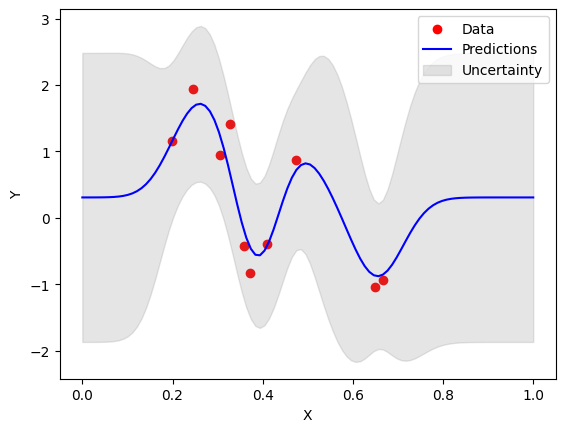

In [ ]:


# Generate some example data
X = np.random.rand(10, 1)  # Input features
Y = np.sin(2 * np.pi * X) +  np.random.randn(10, 1)  # Observed data

# Define a non-zero mean function
mean_function = GPy.mappings.Constant(input_dim=1, output_dim=1, value=5)

# Create a GP regression model with the non-zero mean function
kernel = GPy.kern.RBF(input_dim=1)
model = GPy.models.GPRegression(X, Y, kernel, mean_function=mean_function)

# Optimize the model parameters
model.optimize()

# Make predictions for new input points
X_new = np.linspace(0, 1, 100)[:, None]
Y_pred, Y_var = model.predict(X_new)

# Plot the results
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(X, Y, color='red', label='Data')
plt.plot(X_new, Y_pred, color='blue', label='Predictions')
plt.fill_between(X_new.flatten(), (Y_pred - 2 * np.sqrt(Y_var)).flatten(), (Y_pred + 2 * np.sqrt(Y_var)).flatten(), color='gray', alpha=0.2, label='Uncertainty')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.show()


In [38]:
state_history = collections.deque(maxlen=20)

for i in range(20):
    state_history.append(np.array([1,2,3,4,5,6]))

    
data = np.asarray(list(state_history))[:,0:2]    
print(np.mean(data, axis=0))

[1. 2.]


[[2.     1.     1.    ]
 [1.9511 1.309  1.    ]
 [1.809  1.5878 1.    ]
 [1.5878 1.809  1.    ]
 [1.309  1.9511 1.    ]
 [1.     2.     1.    ]
 [0.691  1.9511 1.    ]
 [0.4122 1.809  1.    ]
 [0.191  1.5878 1.    ]
 [0.0489 1.309  1.    ]
 [0.     1.     1.    ]
 [0.0489 0.691  1.    ]
 [0.191  0.4122 1.    ]
 [0.4122 0.191  1.    ]
 [0.691  0.0489 1.    ]
 [1.     0.     1.    ]
 [1.309  0.0489 1.    ]
 [1.5878 0.191  1.    ]
 [1.809  0.4122 1.    ]
 [1.9511 0.691  1.    ]
 [2.     1.     1.    ]]


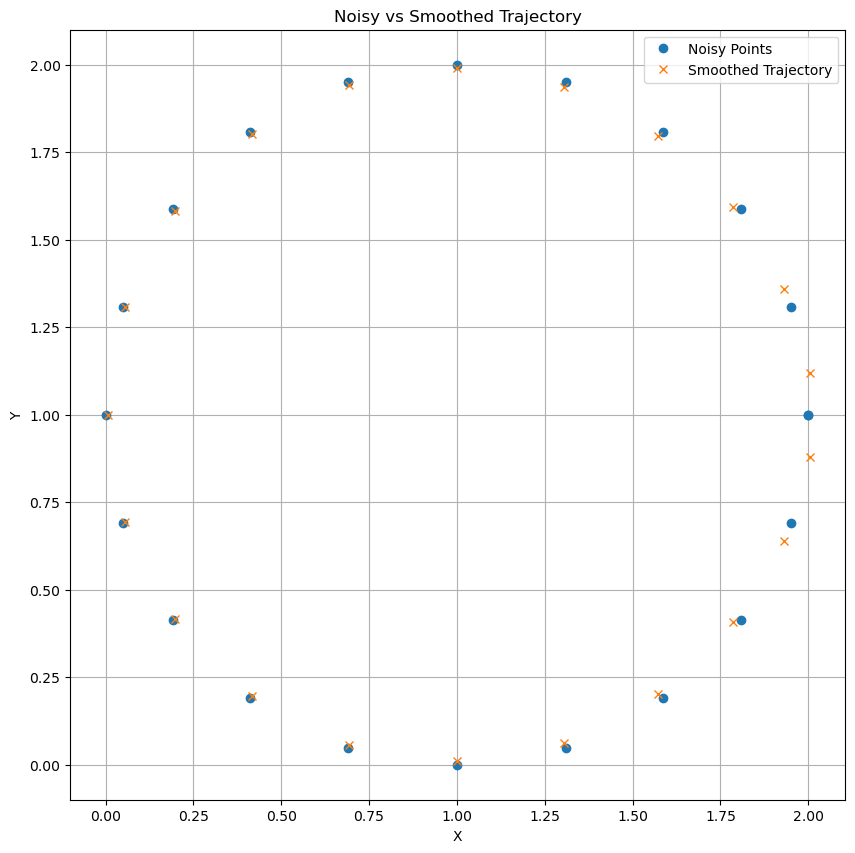

In [34]:

from ccma import CCMA


# Create noisy points on an unit circle
r = 1
d_points = 0.3
n = int(np.ceil(2*np.pi*r/d_points))
x = 1
y = 1
#noise = np.random.normal(0, 0.05, (n, 2))
points = np.array([np.cos(np.linspace(0, 2*np.pi, n))+x,
                   np.sin(np.linspace(0, 2*np.pi, n))+y,
                   np.ones(n)]).T
noisy_points = points

print(points)
# Create ccma-object and smooth points by using padding (default) and Pascal's Triangle kernel/weights (default)
ccma = CCMA(w_ma=5, w_cc=3)
smoothed_points = ccma.filter(noisy_points, mode='wrapping')


# Plot the noisy and smoothed points
plt.figure(figsize=(10, 10))
plt.plot(noisy_points[:, 0], noisy_points[:, 1], 'o', label='Noisy Points')
plt.plot(smoothed_points[:, 0], smoothed_points[:, 1], 'x', label='Smoothed Trajectory')
plt.title('Noisy vs Smoothed Trajectory')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.grid(True)
plt.show()

In [49]:
def calculate_angle(center, base, start):

    
    # Calculate vectors from center to base and center to start
    vector1 = base - center
    vector2 = start - center
    
    # Calculate the dot product of the vectors
    dot_product = np.dot(vector1, vector2)
    
    # Calculate the magnitudes of the vectors
    magnitude1 = np.linalg.norm(vector1)
    magnitude2 = np.linalg.norm(vector2)
    
    # Calculate the cosine of the angle
    cos_angle = dot_product / (magnitude1 * magnitude2)
    
    # Ensure the cosine value is within the valid range for arccos
    cos_angle = np.clip(cos_angle, -1.0, 1.0)
    
    # Calculate the angle in radians
    angle = np.arccos(cos_angle)
    
    return angle

center = np.array([0,0,0])
base = np.array([1,0,0])
start = np.array([0,-1,0])

start_angle = calculate_angle(center, base, start)
n = 20
np.linspace(start_angle, start_angle + 2*np.pi, n)

array([1.5708, 1.9015, 2.2322, 2.5629, 2.8936, 3.2243, 3.555 , 3.8857,
       4.2163, 4.547 , 4.8777, 5.2084, 5.5391, 5.8698, 6.2005, 6.5312,
       6.8619, 7.1926, 7.5233, 7.854 ])

In [1]:
def generate_circle_trajectory(start, center, radius, d_points, yaw):
    
    
    n = int(np.ceil(2*np.pi*radius/d_points))
    x = center[0]
    y = center[1]
    z = center[2]
    #noise = np.random.normal(0, 0.05, (n, 2))
    points = np.array([radius*np.cos(np.linspace(0, 2*np.pi, n)) + x,
                       radius*np.sin(np.linspace(0, 2*np.pi, n)) + y,
                       np.ones(n)*z]).T
    yaw = np.ones((n, 4)) * np.array([1,0,0,0])
    
    return np.hstack((points, yaw))


def generate_trajectory(points, d_points, d_yaw):
    trajectory = []
    for i in range(len(points) - 1):
        vector = points[i + 1][:3] - points[i][:3]
        distance = np.linalg.norm(vector)
        yaw_1 = np.array([1,0,0,0])
        yaw_0 = np.array([1,0,0,0])
        yaw_diff = yaw_1 - yaw_0 
        if yaw_diff > 180:
            yaw_diff -= 360
        elif yaw_diff < -180:
            yaw_diff += 360
        num_points = max(int(np.ceil(distance / d_points)), int(np.ceil(np.abs(yaw_diff) / d_yaw)))
        for j in range(0, num_points ):
            point = points[i][:3] + j * vector / num_points
            yaw = points[i][3] + j * yaw_diff / num_points
            if yaw > 360:
                yaw -= 360
            elif yaw < -360:
                yaw += 360
            
            trajectory.append(np.concatenate((point, np.array([1,0,0,0])), axis=None))
    trajectory.append(points[-1])
    return np.asarray(trajectory)

points = generate_circle_trajectory(np.array([0,1,2]), np.array([-2,0,2]), 2, 0.2, 1)


plt.figure(figsize=(10, 10))
plt.plot(points[:, 0], points[:, 1], 'o', label='Noisy Points')
plt.plot(points[0, 0], points[0, 1], 'x', label='Start')
plt.title('Noisy vs Smoothed Trajectory')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.grid(True)
plt.show()

NameError: name 'np' is not defined

In [7]:
t = np.array([[ 0.0775, -0.0131,  2.0812,  0.9998,  0.  ,    0.    , -0.0212],
 [ 0.0747,  0.0924,  2.0812,  0.9998,  0.  ,    0.    , -0.0212],
 [ 0.0664,  0.1977,  2.0812,  0.9998,  0.  ,    0.    , -0.0212],
 [ 0.0525,  0.3024,  2.0812,  0.9998,  0.  ,    0.    , -0.0212],
 [ 0.0331,  0.4062,  2.0812,  0.9998,  0.  ,    0.    , -0.0212],
 [ 0.0082,  0.5088,  2.0812,  0.9998,  0.  ,    0.    , -0.0212],
 [-0.022 ,  0.6099,  2.0812,  0.9998,  0.  ,    0.    , -0.0212],])

print(t[1,0:3])

[0.0747 0.0924 2.0812]
